In [1]:
# ! pip install colorcet

In [2]:
import torch
import os
import sys
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize
from torchvision.transforms.functional import InterpolationMode
from datasets import load_dataset, Dataset
from transformers import VisionEncoderDecoderModel
from transformers import AutoTokenizer
from transformers import AutoImageProcessor
import pickle
sys.path.append('.')
sys.path.append('..')
sys.path.append('./utils')

import numpy as np
import pandas as pd

# plot
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")
import matplotlib.pyplot as plt

/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.

# Load generated output

In [3]:
path = './output/llama-2-13b-chat-hf_triviaqa_10/0.pkl'
with open(path, 'rb') as f:
    sequences = pickle.load(f)
print(len(sequences))
print(sequences[0])

8000
{'prompt': tensor([    1,   673,  1438,  5155, 29901,    13, 29984, 29901,   512, 15226,
          263,  1716, 29891, 29914, 20313,   347,   338,   263, 29973,    13,
        29909, 29901,  5619,    13, 29984, 29901, 11644,   471,   278,   767,
         5742,   450,   678,   666, 29885, 18801, 29973,    13, 29909, 29901]), 'id': 'tc_2', 'question': 'Who was the man behind The Chipmunks?', 'answer': 'David Seville', 'additional_answers': [], 'most_likely_generation_ids': tensor([4699,  922, 4909,   13]), 'generations_ids': tensor([[11254, 21638,   514,    13,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2],
        [  838,  3845,    13,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2],
        [  838,  3845,    13,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2],
        [11254, 21638,   514,    13,     2,     2,     2,     2,     2,   

In [13]:
tau = 0.3877551020408163    # revealed in saved filename
path = f'./output/llama-2-13b-chat-hf_triviaqa_10/uq_result/scores_{tau}.csv'
summ = pd.read_csv(path)
path = f'./output/llama-2-13b-chat-hf_triviaqa_10/uq_result/labels_{tau}.csv'
lab = np.array(pd.read_csv(path).iloc[:,0].to_list())

ids = summ.iloc[:,0].to_list()
summ_mean = 1 - np.array(summ.mean(1).to_list())
rk = summ_mean.argsort()
lab = lab[rk]
id_min = rk[4000]
id_max = rk[2530]
id_seq = [sequences[ii]['id'] for ii in range(len(sequences))]

id1 = id_seq.index(ids[id_min])
print(sequences[id1]['question'])
print(f"Predicted alignment score: {summ_mean[id_min]}")
print(f"True label: {lab[id_min]}")
print("\nTrue answer:\n")
print(''.join(sequences[id1]['answer'].split('\n')).strip())
print('-------------------------------------------\nGenerated answer:\n')
print(''.join(sequences[id1]['most_likely_generation'].split('\n')).strip())
print(sequences[id1]['generations'])
print('===========================================')
id2 = id_seq.index(ids[id_max])
print(sequences[id2]['question'])
print(f"Predicted alignment score: {summ_mean[id_max]}")
print(f"True label: {lab[id_max]}")
print("\nTrue answer:\n")
print(''.join(sequences[id2]['answer'].split('\n')).strip())
print('-------------------------------------------\nGenerated answer:\n')
print(''.join(sequences[id2]['most_likely_generation'].split('\n')).strip())
print(sequences[id2]['generations'])

An orrery, popular in the 13th and 19th centuries, was a model of what?
Predicted alignment score: 0.8135
True label: 1.0

True answer:

The Solar System
-------------------------------------------
Generated answer:

Solar system
['Solar system\n', 'The solar system (also known as a planetarium)\n', 'Solar System\n', 'The solar system\n', 'Heavenly bodies\n', 'Solar System\n', 'Solar system\n', 'Solar system (with doors and windows)\n', 'Solar system\n', 'Solar System\n', 'Solar system or universe.\n', 'Solar system\n', 'Solar System\n', 'The solar system\n', 'Solar system\n', 'Solar system\n', 'Solar system\n', 'Solar System\n', 'The solar system\n', 'Solar system\n']
In the 1972 film Cabaret, Sally Bowles is working in which club?
Predicted alignment score: 0.5045
True label: 1.0

True answer:

KitKat
-------------------------------------------
Generated answer:

Kit Kat Klub
['Kit Kat Klub\n', 'Kit Kat Club\n', 'Kit Kat\n', 'Kit Kat Klub\n', "Maxim's\n", 'Kit Kat Klub\n', 'KitKat\n'

/var/folders/vf/jr75r1v56hl9tgfz4rv6dh4r0000gn/T/ipykernel_97620/3366710180.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  summ_mean = 1 - np.array(summ.mean(1).to_list())


# Reproduce plots

## Results with varying reference sample size

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 92.95it/s]


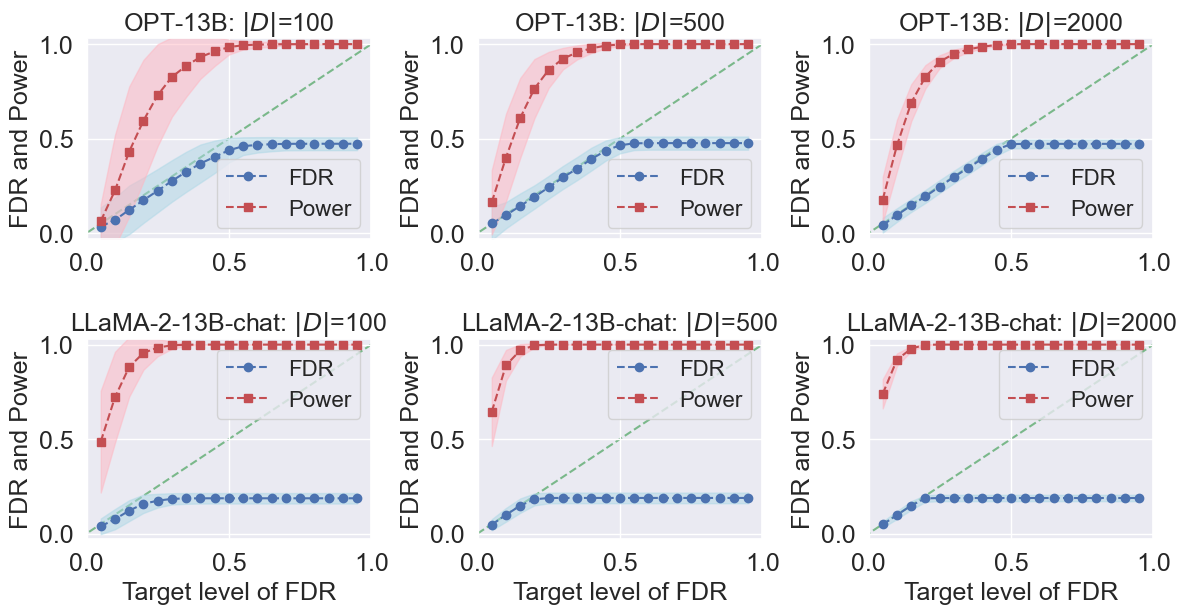

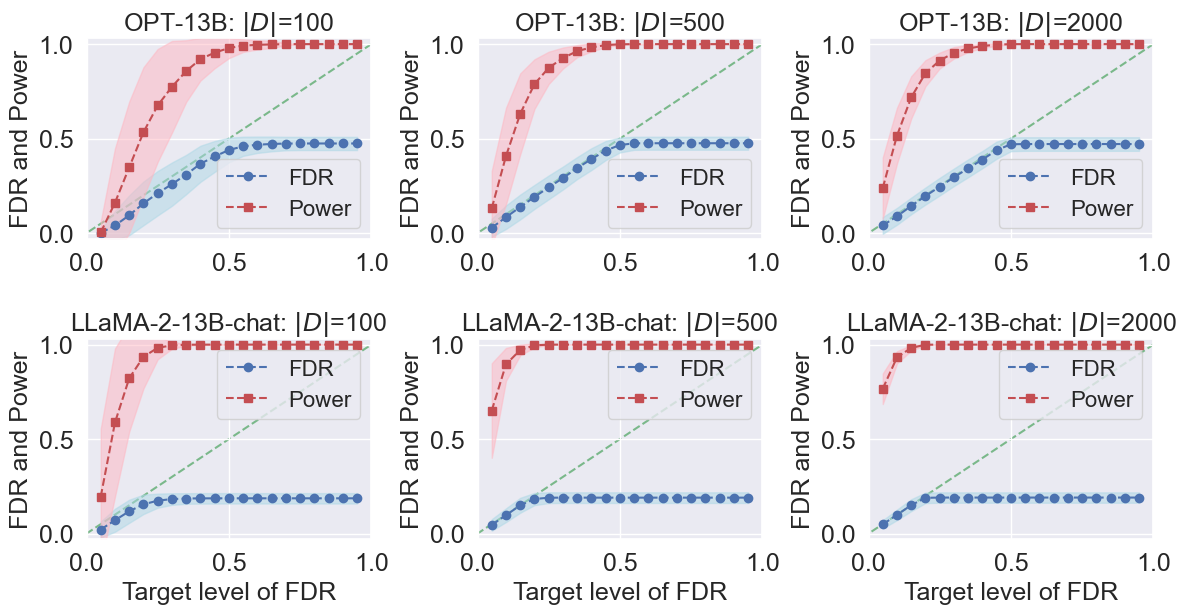

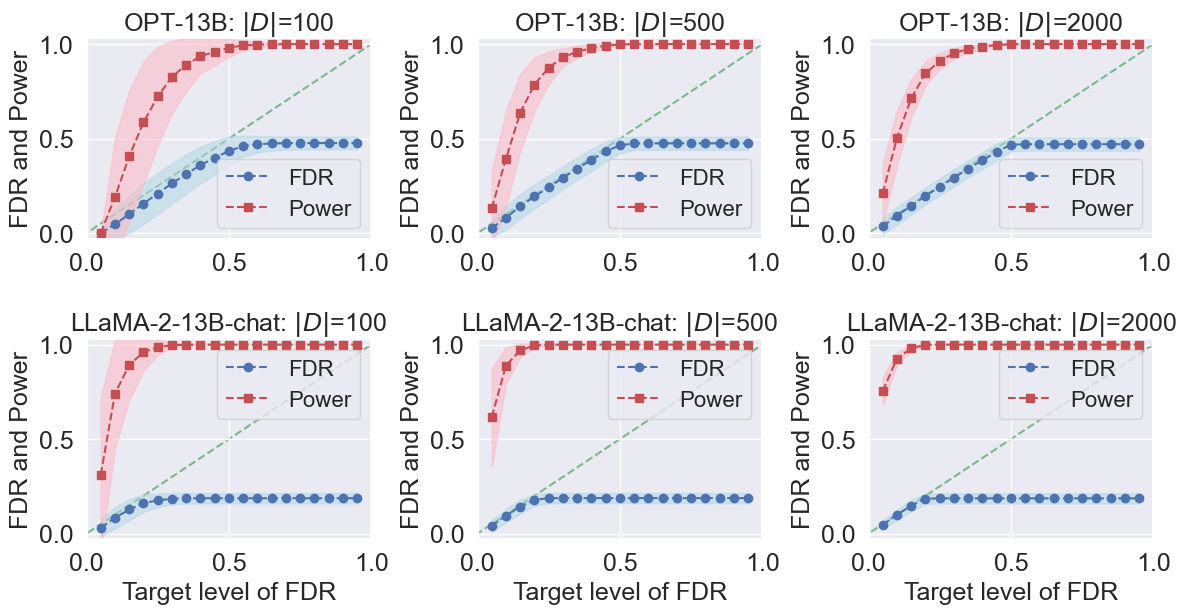

In [19]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

repN = 500
data = 'coqa'
model_name = ['OPT-13B', 'LLaMA-2-13B-chat']

for split_pr_tune in [0.2]:
    for split_pr in [0.5]:
        if split_pr + split_pr_tune<1:
            for uq_name in ['rf', 'logistic', 'xgbrf']:
    
                fig, ax = plt.subplots(2,3,figsize=(12, 6))
                fig.tight_layout()
                plt.subplots_adjust(hspace=0.5)

                xi = 0
                for model in ['opt-13b', 'llama-2-13b-chat-hf']:
                    par_path = f'./output/{model}_{data}_10'

                    q_seq = np.round(np.linspace(0.05,0.95,19),2)
                    train_size_seq = [100, 500, 2000]

                    for i in tqdm(range(len(train_size_seq))):

                        N = train_size_seq[i]

                        path_fdr = os.path.join(par_path, f'uq_result/result/fdr_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                        path_power = os.path.join(par_path, f'uq_result/result/power_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                        path_fdr_std = os.path.join(par_path, f'uq_result/result/fdr_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                        path_power_std = os.path.join(par_path, f'uq_result/result/power_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')

                        with open(path_fdr, 'rb') as f:
                            fdp_seq = pickle.load(f)
                        with open(path_power, 'rb') as f:
                            power_seq = pickle.load(f)
                        with open(path_fdr_std, 'rb') as f:
                            fdp_std = pickle.load(f)
                        with open(path_power_std, 'rb') as f:
                            power_std = pickle.load(f)
                            
                        if len(fdp_seq) > 20:
                            idx_ = np.arange(4,99,5)
                            fdp_seq = fdp_seq[idx_]
                            power_seq = power_seq[idx_]
                            fdp_std = fdp_std[idx_]
                            power_std = power_std[idx_]


                        ax[xi,i].plot(q_seq, fdp_seq, 'bo--', label='FDR')
                        ax[xi,i].plot(q_seq, power_seq, 'rs--', label='Power')
                        ax[xi,i].fill_between(q_seq, fdp_seq-fdp_std, fdp_seq+fdp_std, alpha=0.5, 
                            edgecolor='lightblue', facecolor='lightblue')
                        ax[xi,i].fill_between(q_seq, power_seq-power_std, power_seq+power_std, alpha=0.5, 
                            edgecolor='lightpink', facecolor='lightpink')
                    
                        if xi==1:
                            ax[xi,i].set_xlabel("Target level of FDR")
                        ax[xi,i].set_ylabel("FDR and Power")

                        lims = [
                            np.min([ax[xi,i].get_xlim(), ax[xi,i].get_ylim()]),  # min of both axes
                            np.max([ax[xi,i].get_xlim(), ax[xi,i].get_ylim()]),  # max of both axes
                        ]
                        ax[xi,i].plot(lims, lims, 'g--', alpha=0.75, zorder=0)
                        ax[xi,i].set_title(r'%s: $|D|$=%s'%(model_name[xi],N,))
                        ax[xi,i].set_xlim(lims)
                        ax[xi,i].set_ylim(lims)
                        ax[xi,i].set_xlim((0,1))
                        ax[xi,i].set_ylim((-0.03,1.03))
                        ax[xi,i].legend(loc='best', prop = { "size": 16 })

                    xi += 1

                plot_dir = f'./plots/fdp_plot_{data}_{uq_name}_{split_pr_tune}_{split_pr}_{repN}.pdf'
                plt.savefig(plot_dir, dpi=400, bbox_inches='tight')



## Results with varying $\gamma_1$: sample size for parameter tuning

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 104.54it/s]


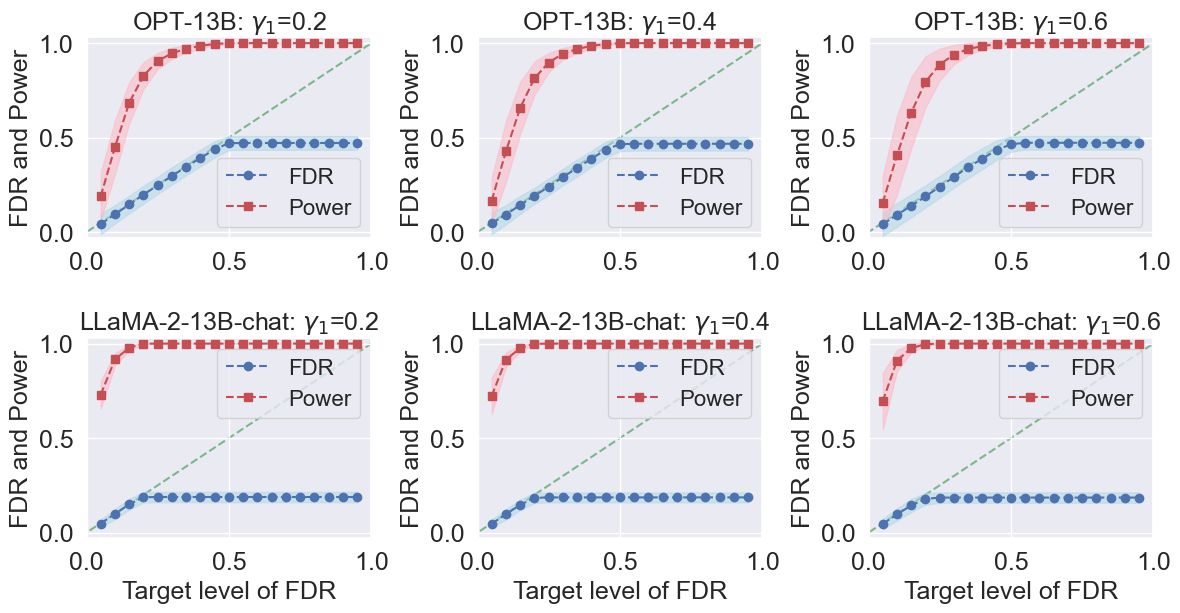

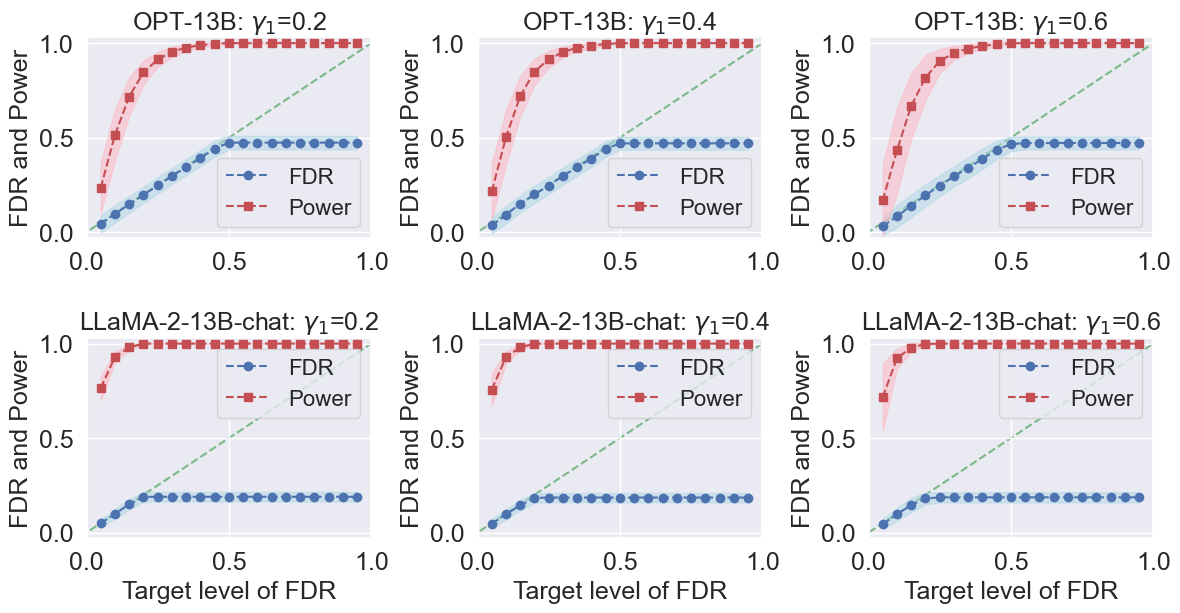

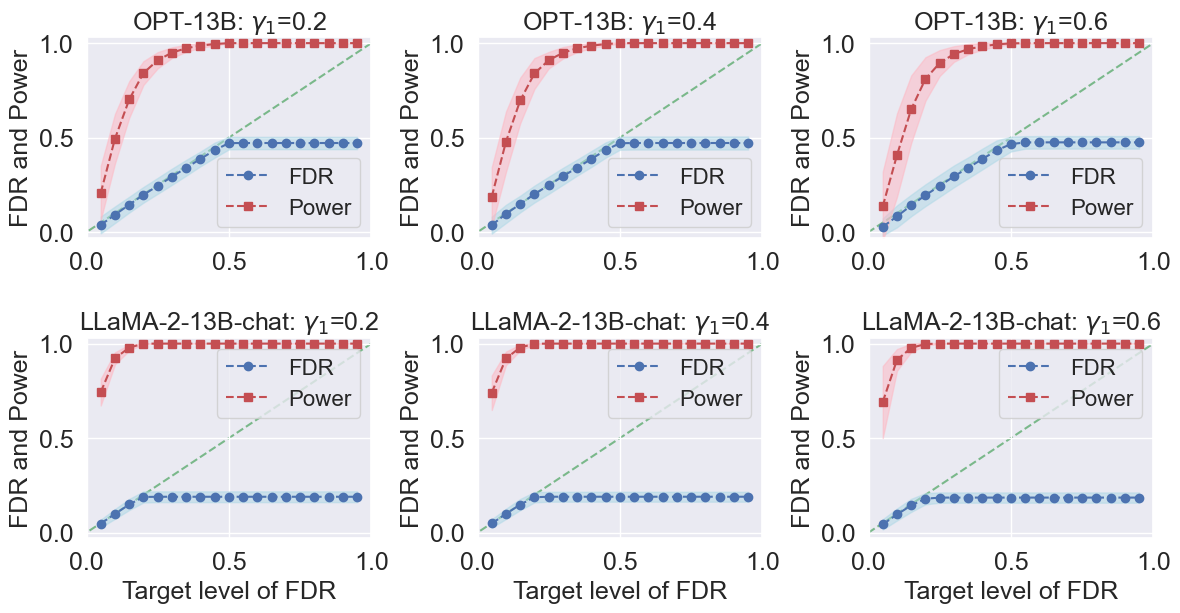

In [20]:
# vary split_pr_tune

repN = 500
data = 'coqa'
model_name = ['OPT-13B', 'LLaMA-2-13B-chat']
train_size_seq = [2000]
pr_tune_seq = [0.2,0.4,0.6]

for N in train_size_seq:
    for split_pr in [0.3]:
        if split_pr + split_pr_tune<1:
            for uq_name in ['rf', 'logistic', 'xgbrf']:
    
                fig, ax = plt.subplots(2,3,figsize=(12, 6))
                fig.tight_layout()
                plt.subplots_adjust(hspace=0.5)

                xi = 0
                for model in ['opt-13b', 'llama-2-13b-chat-hf']:
                    par_path = f'./output/{model}_{data}_10'

                    q_seq = np.round(np.linspace(0.05,0.95,19),2)

                    for i in tqdm(range(len(pr_tune_seq))):
                        
                        split_pr_tune = pr_tune_seq[i]

                        path_fdr = os.path.join(par_path, f'uq_result/result/fdr_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                        path_power = os.path.join(par_path, f'uq_result/result/power_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                        path_fdr_std = os.path.join(par_path, f'uq_result/result/fdr_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                        path_power_std = os.path.join(par_path, f'uq_result/result/power_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')

                        with open(path_fdr, 'rb') as f:
                            fdp_seq = pickle.load(f)
                        with open(path_power, 'rb') as f:
                            power_seq = pickle.load(f)
                        with open(path_fdr_std, 'rb') as f:
                            fdp_std = pickle.load(f)
                        with open(path_power_std, 'rb') as f:
                            power_std = pickle.load(f)
                            
                        if len(fdp_seq) > 20:
                            idx_ = np.arange(4,99,5)
                            fdp_seq = fdp_seq[idx_]
                            power_seq = power_seq[idx_]
                            fdp_std = fdp_std[idx_]
                            power_std = power_std[idx_]


                        ax[xi,i].plot(q_seq, fdp_seq, 'bo--', label='FDR')
                        ax[xi,i].plot(q_seq, power_seq, 'rs--', label='Power')
                        ax[xi,i].fill_between(q_seq, fdp_seq-fdp_std, fdp_seq+fdp_std, alpha=0.5, 
                            edgecolor='lightblue', facecolor='lightblue')
                        ax[xi,i].fill_between(q_seq, power_seq-power_std, power_seq+power_std, alpha=0.5, 
                            edgecolor='lightpink', facecolor='lightpink')
                    
                        if xi==1:
                            ax[xi,i].set_xlabel("Target level of FDR")
                        ax[xi,i].set_ylabel("FDR and Power")

                        lims = [
                            np.min([ax[xi,i].get_xlim(), ax[xi,i].get_ylim()]),  # min of both axes
                            np.max([ax[xi,i].get_xlim(), ax[xi,i].get_ylim()]),  # max of both axes
                        ]
                        ax[xi,i].plot(lims, lims, 'g--', alpha=0.75, zorder=0)
                        ax[xi,i].set_title(r'%s: $\gamma_1$=%s'%(model_name[xi],split_pr_tune,))
                        ax[xi,i].set_xlim(lims)
                        ax[xi,i].set_ylim(lims)
                        ax[xi,i].set_xlim((0,1))
                        ax[xi,i].set_ylim((-0.03,1.03))
                        ax[xi,i].legend(loc='best', prop = { "size": 16 })

                    xi += 1

                plot_dir = f'./plots/fdp_plot_gamma_1_{data}_{uq_name}_{N}_{split_pr}_{repN}.pdf'
                plt.savefig(plot_dir, dpi=400, bbox_inches='tight')



## Results with varying $\gamma_2$: sample size for training the alignment score predictor

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 111.94it/s]


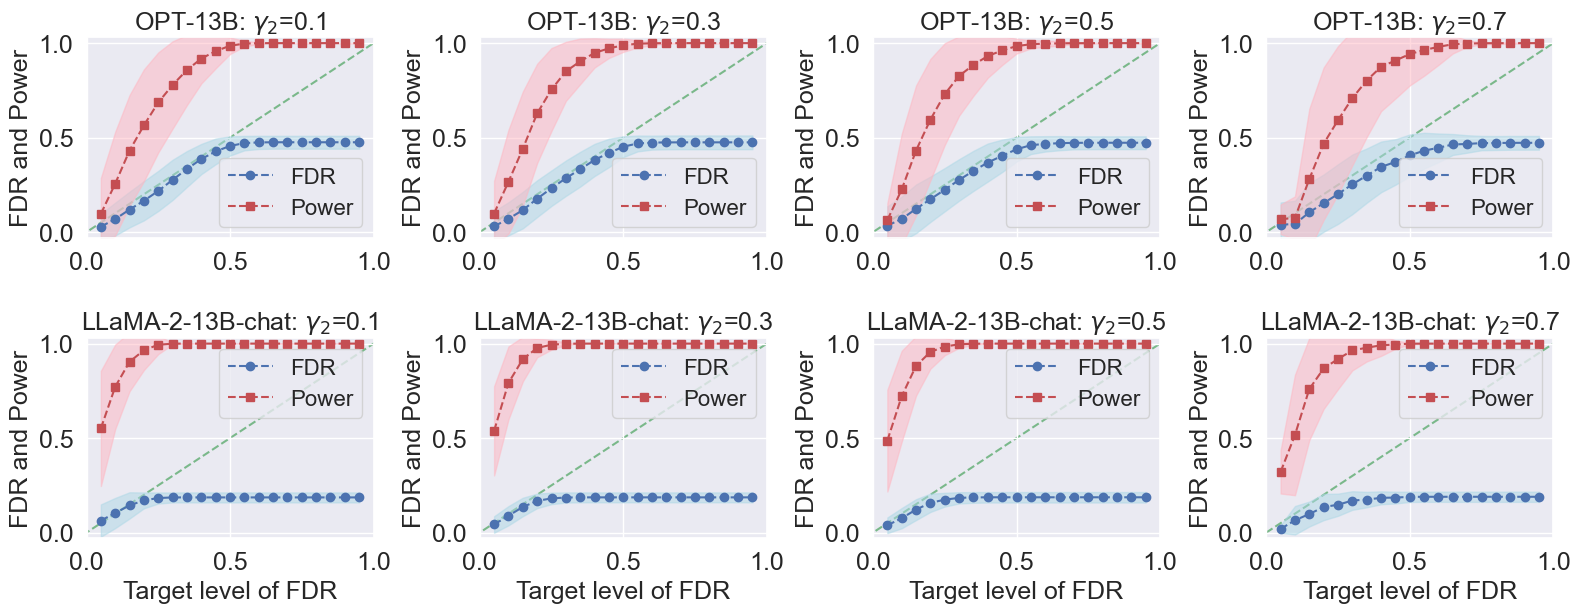

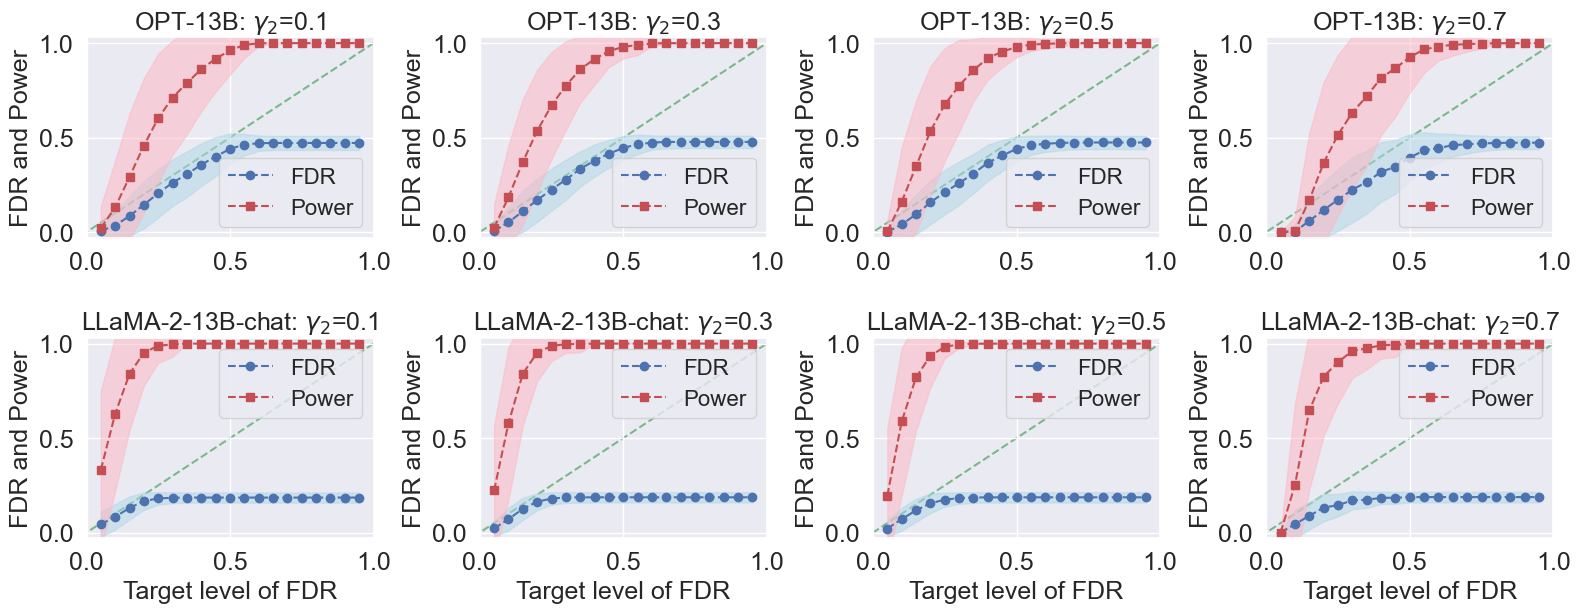

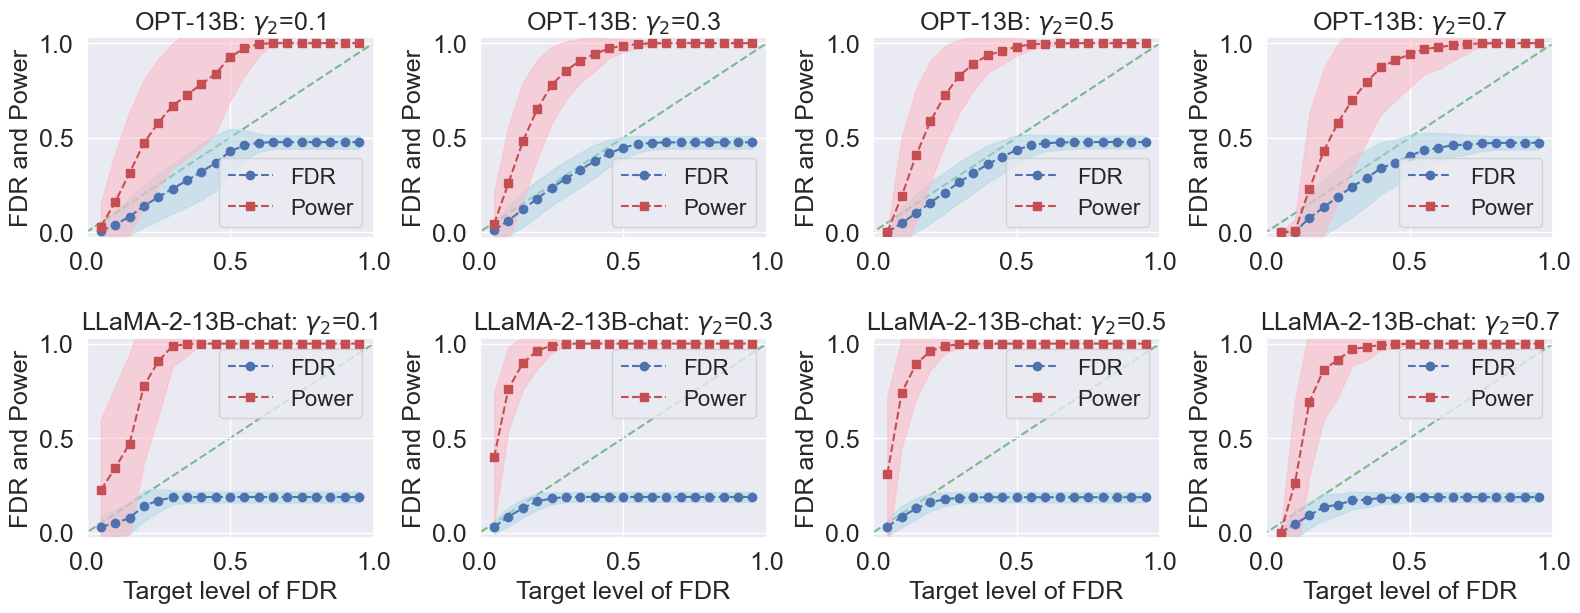

In [22]:
# vary split_pr

repN = 500
data = 'coqa'
model_name = ['OPT-13B', 'LLaMA-2-13B-chat']
train_size_seq = [100]
pr_seq = [0.1,0.3,0.5,0.7]

for N in train_size_seq:
    for split_pr_tune in [0.2]:
        for uq_name in ['rf', 'logistic', 'xgbrf']:

            fig, ax = plt.subplots(2,len(pr_seq),figsize=(4*len(pr_seq), 6))
            fig.tight_layout()
            plt.subplots_adjust(hspace=0.5)

            xi = 0
            for model in ['opt-13b', 'llama-2-13b-chat-hf']:
                par_path = f'./output/{model}_{data}_10'

                q_seq = np.round(np.linspace(0.05,0.95,19),2)

                for i in tqdm(range(len(pr_seq))):

                    split_pr = pr_seq[i]

                    path_fdr = os.path.join(par_path, f'uq_result/result/fdr_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                    path_power = os.path.join(par_path, f'uq_result/result/power_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                    path_fdr_std = os.path.join(par_path, f'uq_result/result/fdr_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                    path_power_std = os.path.join(par_path, f'uq_result/result/power_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')

                    with open(path_fdr, 'rb') as f:
                        fdp_seq = pickle.load(f)
                    with open(path_power, 'rb') as f:
                        power_seq = pickle.load(f)
                    with open(path_fdr_std, 'rb') as f:
                        fdp_std = pickle.load(f)
                    with open(path_power_std, 'rb') as f:
                        power_std = pickle.load(f)
                        
                    if len(fdp_seq) > 20:
                        idx_ = np.arange(4,99,5)
                        fdp_seq = fdp_seq[idx_]
                        power_seq = power_seq[idx_]
                        fdp_std = fdp_std[idx_]
                        power_std = power_std[idx_]


                    ax[xi,i].plot(q_seq, fdp_seq, 'bo--', label='FDR')
                    ax[xi,i].plot(q_seq, power_seq, 'rs--', label='Power')
                    ax[xi,i].fill_between(q_seq, fdp_seq-fdp_std, fdp_seq+fdp_std, alpha=0.5, 
                        edgecolor='lightblue', facecolor='lightblue')
                    ax[xi,i].fill_between(q_seq, power_seq-power_std, power_seq+power_std, alpha=0.5, 
                        edgecolor='lightpink', facecolor='lightpink')

                    if xi==1:
                        ax[xi,i].set_xlabel("Target level of FDR")
                    ax[xi,i].set_ylabel("FDR and Power")

                    lims = [
                        np.min([ax[xi,i].get_xlim(), ax[xi,i].get_ylim()]),  # min of both axes
                        np.max([ax[xi,i].get_xlim(), ax[xi,i].get_ylim()]),  # max of both axes
                    ]
                    ax[xi,i].plot(lims, lims, 'g--', alpha=0.75, zorder=0)
                    ax[xi,i].set_title(r'%s: $\gamma_2$=%s'%(model_name[xi],split_pr,))
                    ax[xi,i].set_xlim(lims)
                    ax[xi,i].set_ylim(lims)
                    ax[xi,i].set_xlim((0,1))
                    ax[xi,i].set_ylim((-0.03,1.03))
                    ax[xi,i].legend(loc='best', prop = { "size": 16 })

                xi += 1

            plot_dir = f'./plots/fdp_plot_gamma_2_{data}_{uq_name}_{N}_{split_pr_tune}_{repN}.pdf'
            plt.savefig(plot_dir, dpi=400, bbox_inches='tight')



## Effect of features in alignment score predictor

(13, 99)
(13, 99)


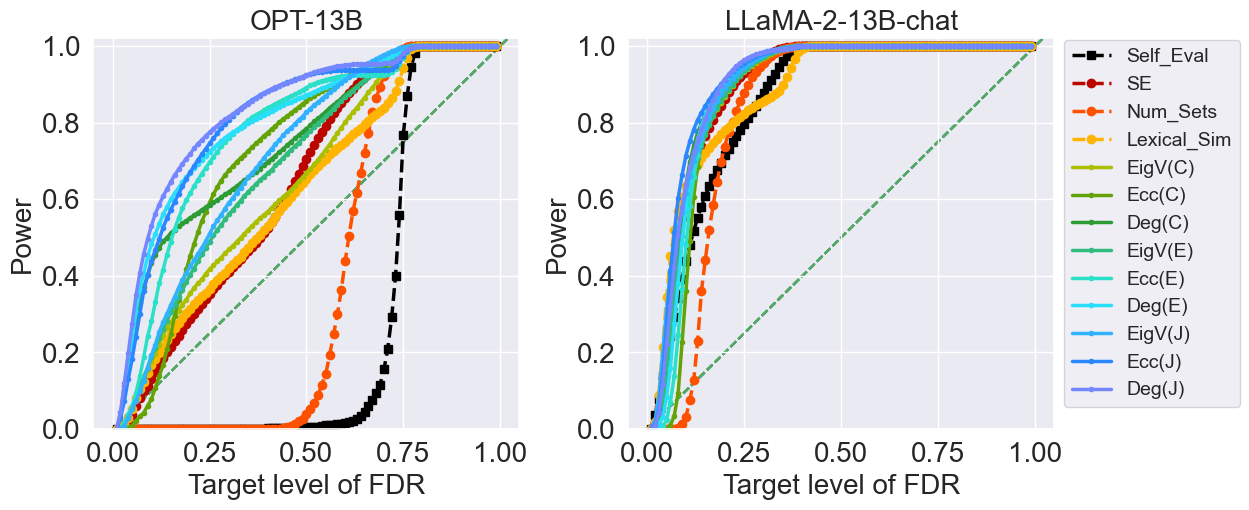

In [29]:
import colorcet as cc
from matplotlib.cm import get_cmap

# plot
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")
import matplotlib.pyplot as plt
SMALL_SIZE = 14
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# ROC
data = 'triviaqa'
model = 'opt-13b'
N = 2000
uq_name = 'logistic'
split_pr_tune = 0.2
split_pr = 0.5
repN = 500
model_name = ['OPT-13B', 'LLaMA-2-13B-chat']
uq_list = [
        'generations|numsets', 
        'lexical_sim',
        'generations|spectral_eigv_clip|disagreement_w',
        'generations|eccentricity|disagreement_w',
        'generations|degree|disagreement_w',
        'generations|spectral_eigv_clip|agreement_w',
        'generations|eccentricity|agreement_w',
        'generations|degree|agreement_w',
        'generations|spectral_eigv_clip|jaccard',
        'generations|eccentricity|jaccard',
        'generations|degree|jaccard',
        'semanticEntropy|unnorm', 
        'self_prob',
]
def name_map(v):
    if v == 'self_prob': return "Self_Eval"
    if v == 'lexical_sim': return "Lexical_Sim"
    v = v.replace("|numsets", "|Num_Sets")
    v = v.replace("|disagreement_w", "|(C)")
    v = v.replace("|agreement_w", "|(E)")
    v = v.replace("|jaccard", "|(J)")
    v = v.replace("spectral_eigv_clip|", "EigV")
    v = v.replace("eccentricity|", "Ecc")
    v = v.replace("degree|", "Deg")
    return {'semanticEntropy|unnorm': 'SE',
            'blind': 'Basse Accuracy'}.get(v,v)
    return v

xi = 0

q_seq = np.round(np.linspace(0.01,0.99,99),2)
fig, ax = plt.subplots(1,2,figsize=(11, 5))
fig.tight_layout()
    
for model in ['opt-13b', 'llama-2-13b-chat-hf']:
    par_path = f'./output/{model}_{data}_10'
    path_fdr = os.path.join(par_path, f'uq_result/result/uq_fdr_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
    path_power = os.path.join(par_path, f'uq_result/result/uq_power_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
    with open(path_fdr, 'rb') as f:
        fdr_uq = pickle.load(f)
    with open(path_power, 'rb') as f:
        power_uq = pickle.load(f)
    print(fdr_uq.shape)

    idx_seq = [len(fdr_uq)-1, len(fdr_uq)-2] + [i for i in range(len(fdr_uq)-2)]

    for i in range(len(idx_seq)):
        i_ = idx_seq[i]
        fdp_seq = fdr_uq[i_]
        power_seq = power_uq[i_]
        uq_nam = name_map(uq_list[i_])
        uq_nam = uq_nam.split('generations|')[-1]
        
        if uq_nam == 'Self_Eval':
            color = 'black'
            mark = 's'
            lty = '--'
        elif uq_nam in ['Num_Sets', 'SE', 'Lexical_Sim']:
            color = cc.fire[50*(i+1)]
            mark = 'o'
            lty = '--'
        else:
            color = cc.CET_C6[15*i]
            mark = '.'
            lty = '-'

        val = "Power"
        if val == 'FDR':
            val_seq = fdp_seq
        else:
            val_seq = power_seq
        
        ax[xi].plot(q_seq, val_seq, linestyle=lty, marker=mark, markersize=6, linewidth=2.5, label=uq_nam, c=color)
        ax[xi].set_xlabel("Target level of FDR")
        ax[xi].set_ylabel(val)

        lims = [
            np.min([ax[xi].get_xlim(), ax[xi].get_ylim()]),  # min of both axes
            np.max([ax[xi].get_xlim(), ax[xi].get_ylim()]),  # max of both axes
        ]
        ax[xi].plot(lims, lims, 'g--', alpha=0.75, zorder=0)
        ax[xi].set_xlim(lims)
        ax[xi].set_ylim(lims)
        ax[xi].set_ylim((0,1.02))
        ax[xi].set_title(r'%s'%(model_name[xi],))
    xi += 1
ax[1].legend(loc='best',bbox_to_anchor=(1, 1.02))

plt.savefig(f'./plots/ROC _{val}_plot_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pdf', dpi=400, bbox_inches='tight')

## Comparison with the baseline

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


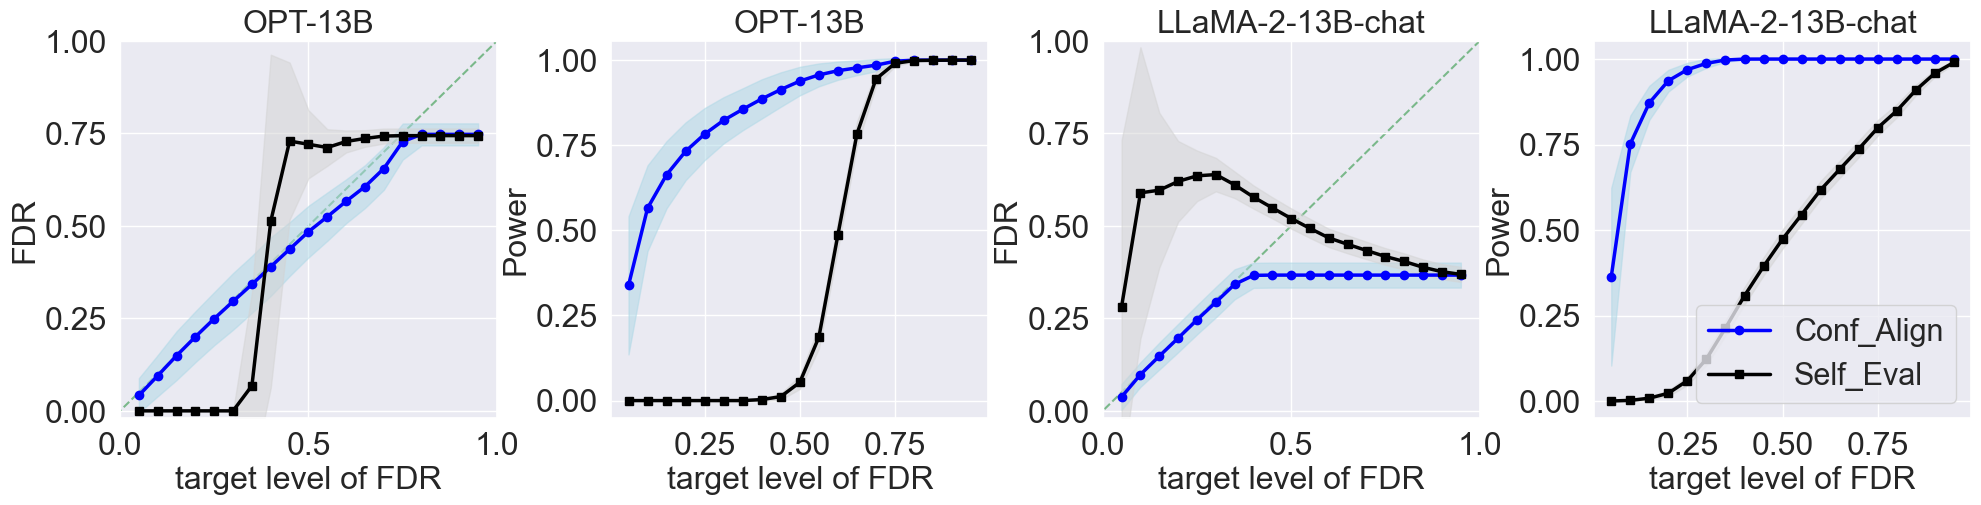

In [18]:
# ROC
SMALL_SIZE = 22
MEDIUM_SIZE = 23
BIGGER_SIZE = 23

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



data = 'triviaqa'
# model = 'llama-2-13b-chat-hf'
model = 'opt-13b'
model_seq = ['opt-13b', 'llama-2-13b-chat-hf']
N = 2000
uq_name = 'logistic'
split_pr_tune = 0.2
split_pr = 0.5
repN = 500
model_name = ['OPT-13B', 'LLaMA-2-13B-chat']
uq_list = [
        'generations|numsets', 
        'lexical_sim',
        'generations|spectral_eigv_clip|disagreement_w',
        'generations|eccentricity|disagreement_w',
        'generations|degree|disagreement_w',
        'generations|spectral_eigv_clip|agreement_w',
        'generations|eccentricity|agreement_w',
        'generations|degree|agreement_w',
        'generations|spectral_eigv_clip|jaccard',
        'generations|eccentricity|jaccard',
        'generations|degree|jaccard',
        'semanticEntropy|unnorm', 
        'self_prob',
]
uq_list0 = [
    'generations|numsets', 
    'semanticEntropy|unnorm', 
    'generations|eccentricity|jaccard',
    'generations|degree|jaccard',
]
def name_map(v):
    if v == 'self_prob': return "Self_Eval"
    if v == 'lexical_sim': return "Lexical_Sim"
    v = v.replace("|numsets", "|Num_Sets")
    v = v.replace("|disagreement_w", "|(C)")
    v = v.replace("|agreement_w", "|(E)")
    v = v.replace("|jaccard", "|(J)")
    v = v.replace("spectral_eigv_clip|", "EigV")
    v = v.replace("eccentricity|", "Ecc")
    v = v.replace("degree|", "Deg")
    return {'semanticEntropy|unnorm': 'SE',
            'blind': 'Basse Accuracy'}.get(v,v)
    return v


fig, ax = plt.subplots(1,4,figsize=(20, 5))
fig.tight_layout()
q_seq = np.linspace(0.05,0.95,19)

for xi in range(2):
    
    model = model_seq[xi]
    par_path = f'./output/{model}_{data}_10'
    path_fdr_ptrue = os.path.join(par_path, f'uq_result/result/baseline_ptrue_fdr_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
    path_power_ptrue = os.path.join(par_path, f'uq_result/result/baseline_ptrue_power_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
    path_fdr_std_ptrue = os.path.join(par_path, f'uq_result/result/baseline_ptrue_fdr_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
    path_power_std_ptrue = os.path.join(par_path, f'uq_result/result/baseline_ptrue_power_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
    with open(path_fdr_ptrue, 'rb') as f:
        fdp_base_ptrue = pickle.load(f).ravel()
    with open(path_power_ptrue, 'rb') as f:
        power_base_ptrue = pickle.load(f).ravel()
    with open(path_fdr_std_ptrue, 'rb') as f:
        fdp_std_base_ptrue = pickle.load(f).ravel()
    with open(path_power_std_ptrue, 'rb') as f:
        power_std_base_ptrue = pickle.load(f).ravel()

    path_fdr_ = os.path.join(par_path, f'uq_result/result/fdr_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
    path_power_ = os.path.join(par_path, f'uq_result/result/power_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
    path_fdr_std = os.path.join(par_path, f'uq_result/result/fdr_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
    path_power_std = os.path.join(par_path, f'uq_result/result/power_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
    with open(path_fdr_, 'rb') as f:
        fdp_seq0 = pickle.load(f)
    with open(path_power_, 'rb') as f:
        power_seq0 = pickle.load(f)
    with open(path_fdr_std, 'rb') as f:
        fdp_std = pickle.load(f)
    with open(path_power_std, 'rb') as f:
        power_std = pickle.load(f)

    ax[xi*2].plot(q_seq, fdp_seq0, linestyle='-', marker='o', markersize=6, linewidth=2.5, label='Conf_Align', c='blue')
    ax[xi*2+1].plot(q_seq, power_seq0, linestyle='-', marker='o', markersize=6, linewidth=2.5, label='Conf_Align', c='blue')
    ax[xi*2].fill_between(q_seq, fdp_seq0-fdp_std, fdp_seq0+fdp_std, alpha=0.5, 
        edgecolor='lightblue', facecolor='lightblue')
    ax[xi*2+1].fill_between(q_seq, power_seq0-power_std, power_seq0+power_std, alpha=0.5, 
        edgecolor='lightblue', facecolor='lightblue')

    ax[xi*2].plot(q_seq, fdp_base_ptrue, linestyle='-', marker='s', markersize=6, linewidth=2.5, label='Self_Eval', c='black')
    ax[xi*2+1].plot(q_seq, power_base_ptrue, linestyle='-', marker='s', markersize=6, linewidth=2.5, label='Self_Eval', c='black')
    ax[xi*2].fill_between(q_seq, fdp_base_ptrue-fdp_std_base_ptrue, fdp_base_ptrue+fdp_std_base_ptrue, alpha=0.5, 
        edgecolor='lightgray', facecolor='lightgray')
    ax[xi*2+1].fill_between(q_seq, power_base_ptrue-power_std_base_ptrue, power_base_ptrue+power_std_base_ptrue, alpha=0.5, 
        edgecolor='lightgray', facecolor='lightgray')

    ax[xi*2].set_xlabel("target level of FDR")
    ax[xi*2].set_ylabel("FDR")
    ax[xi*2+1].set_xlabel("target level of FDR")
    ax[xi*2+1].set_ylabel("Power")

    lims = [
        np.min([ax[xi*2].get_xlim(), ax[xi*2].get_ylim()]),  # min of both axes
        np.max([ax[xi*2].get_xlim(), ax[xi*2].get_ylim()]),  # max of both axes
    ]
    ax[xi*2].plot(lims, lims, 'g--', alpha=0.75, zorder=0)
    ax[xi*2].set_xlim((0,1))
    ax[xi*2].set_ylim((-0.02,1))
    ax[xi*2].set_title(model_name[xi])
    ax[xi*2+1].set_title(model_name[xi])
    ax[3].legend(loc='lower right')

    plt.savefig(f'./plots/baseline_plot_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pdf', dpi=400, bbox_inches='tight')